Table Top Flood Model - Deterministic Periodic Forcing Experiments

Running experiment with square wave forcing
Starting periodic experiment with square wave forcing...
Period: 1000s, Rain duration: 500s, Total time: 8000s
Simulation completed in 15.97 seconds
Total time steps: 116024


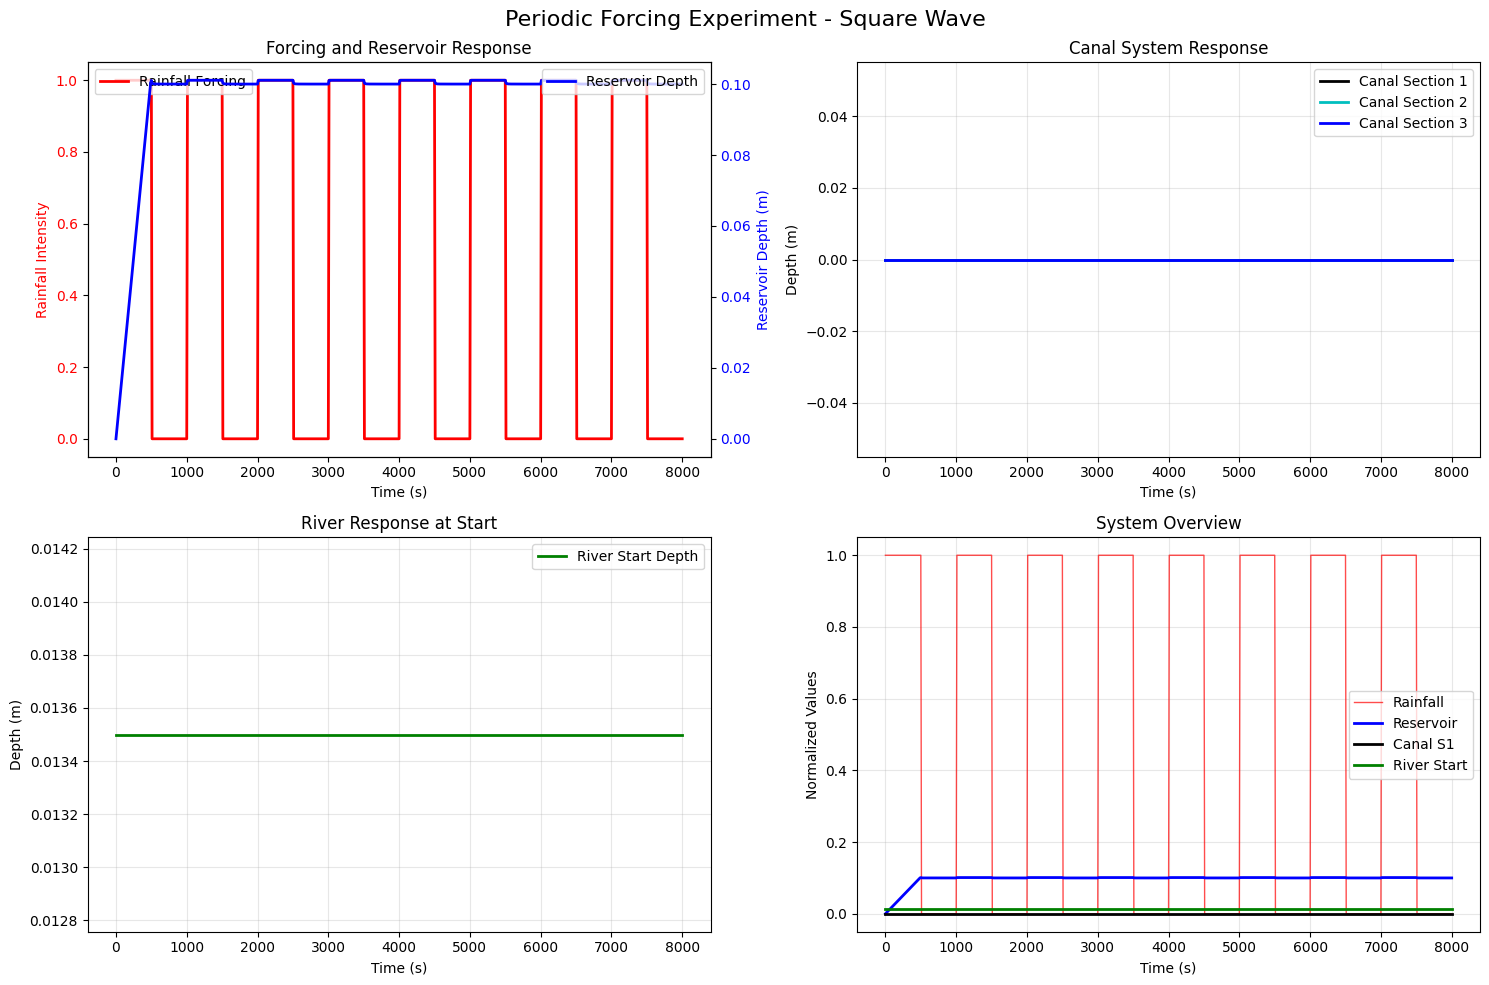


Results for square wave:
Max reservoir depth: 0.1011 m
Max canal section 1 depth: 0.0000 m
Max river depth: 0.0135 m
Rain cycles completed: 8

Running experiment with sine wave forcing
Starting periodic experiment with sine wave forcing...
Period: 1000s, Rain duration: 500s, Total time: 8000s
Simulation completed in 15.97 seconds
Total time steps: 116025


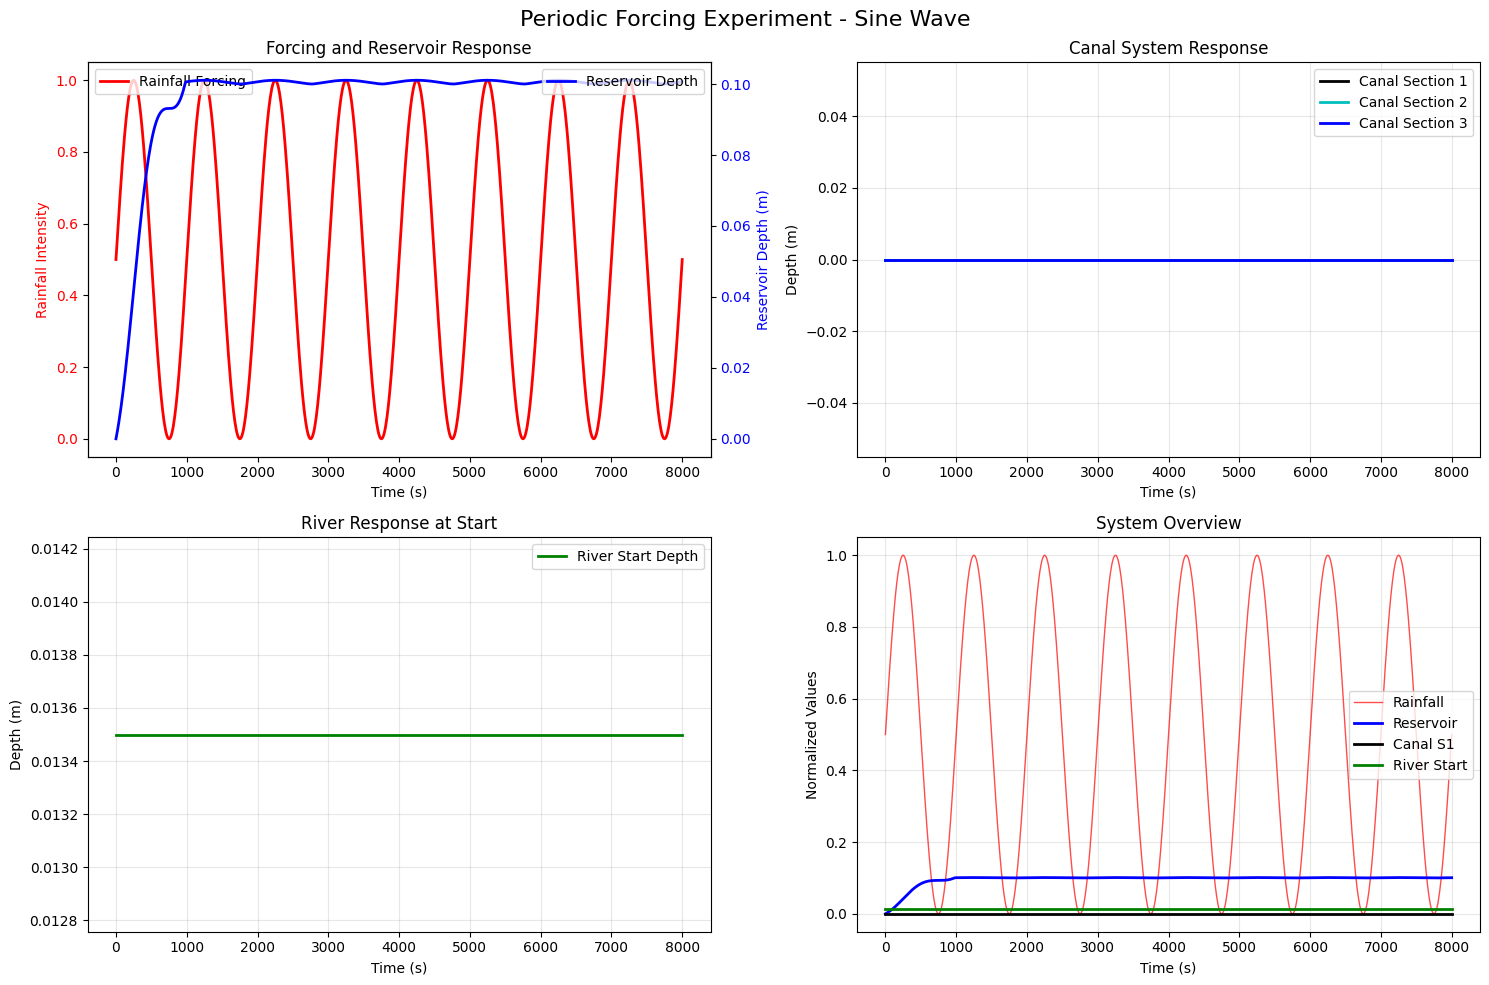


Results for sine wave:
Max reservoir depth: 0.1011 m
Max canal section 1 depth: 0.0000 m
Max river depth: 0.0135 m
Rain cycles completed: 8

Running experiment with pulse wave forcing
Starting periodic experiment with pulse wave forcing...
Period: 1000s, Rain duration: 500s, Total time: 8000s
Simulation completed in 15.90 seconds
Total time steps: 115359


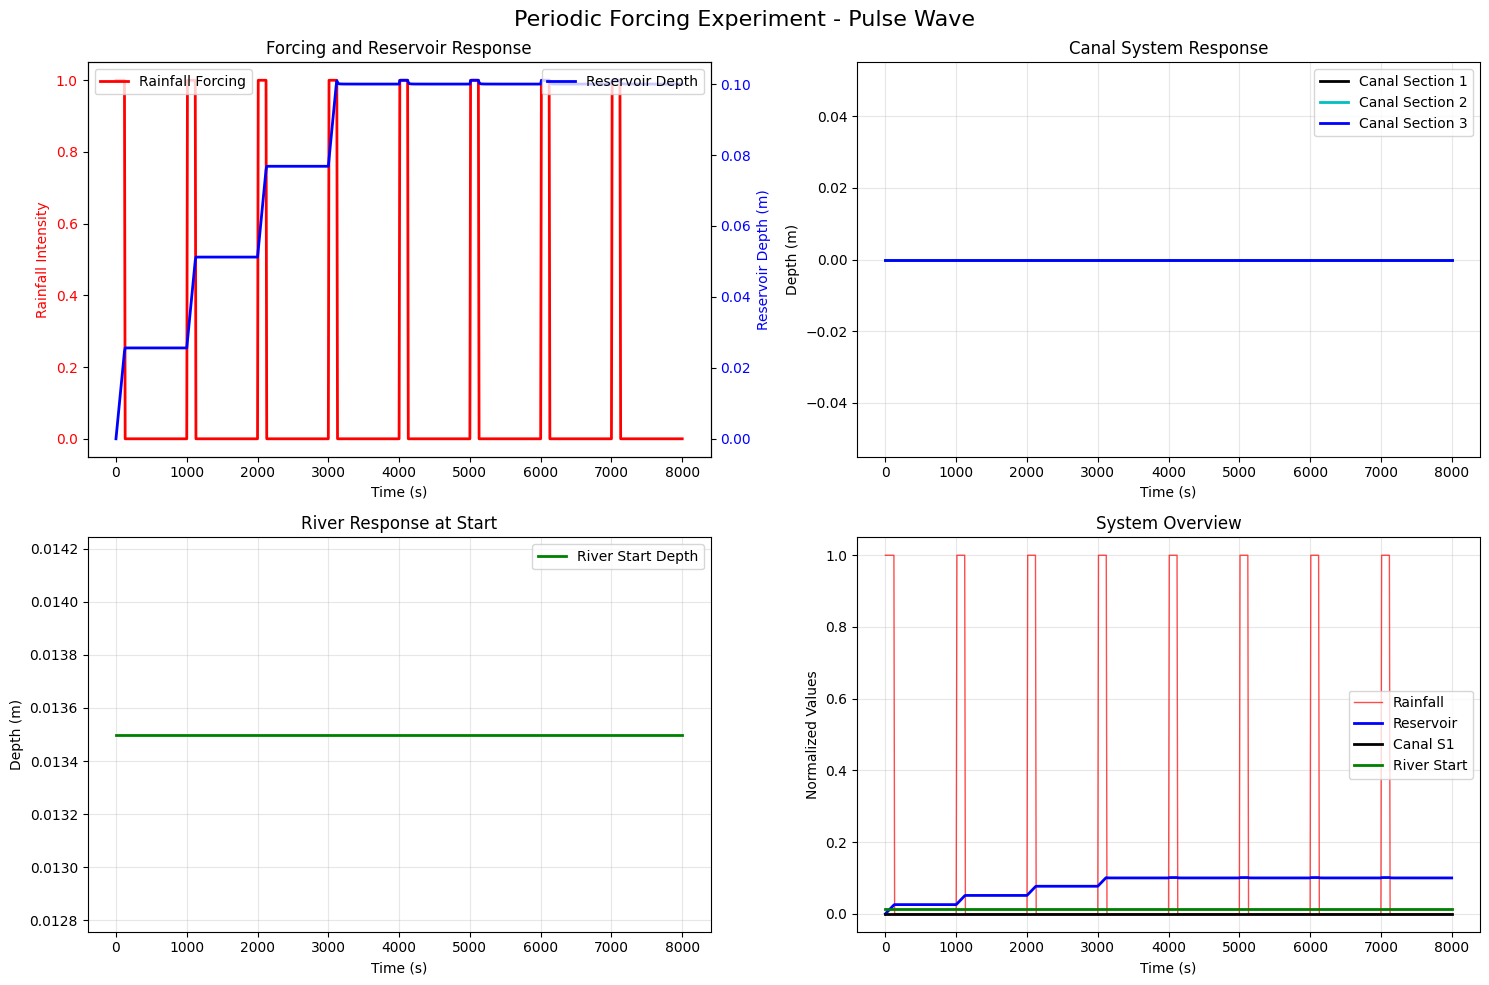


Results for pulse wave:
Max reservoir depth: 0.1011 m
Max canal section 1 depth: 0.0000 m
Max river depth: 0.0135 m
Rain cycles completed: 8

Running experiment with custom wave forcing
Starting periodic experiment with custom wave forcing...
Period: 1000s, Rain duration: 500s, Total time: 8000s
Simulation completed in 25.66 seconds
Total time steps: 115235


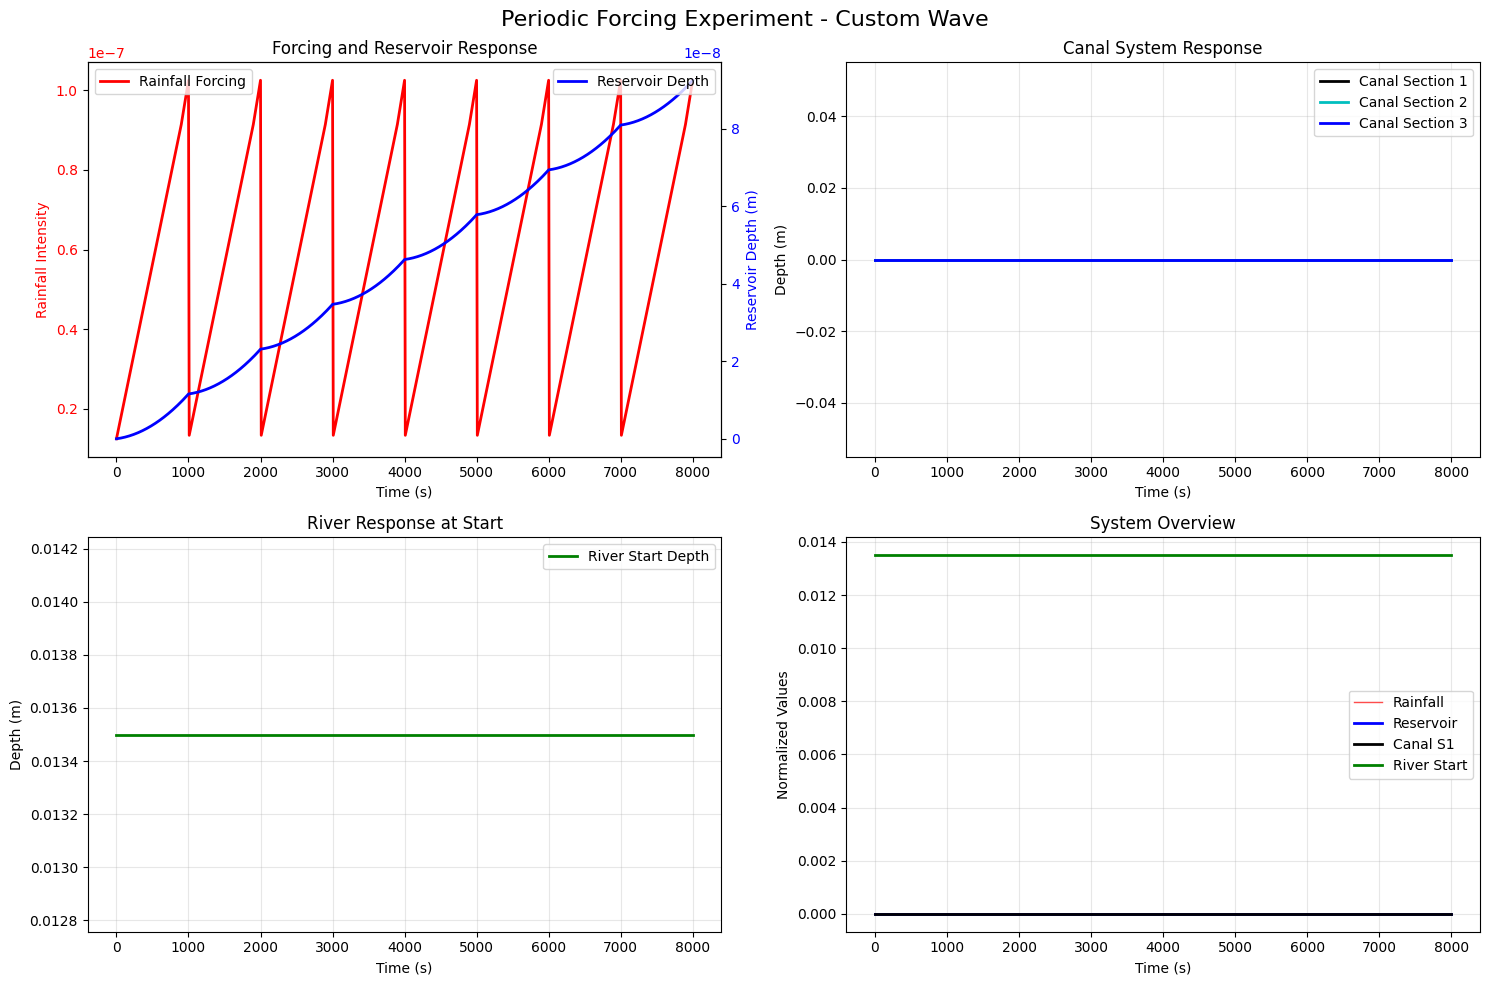


Results for custom wave:
Max reservoir depth: 0.0000 m
Max canal section 1 depth: 0.0000 m
Max river depth: 0.0135 m
Rain cycles completed: 8


In [ ]:
# -*- coding: utf-8 -*-
"""
A hydrological model simulating canal-river-moor-reservoir system dynamics

Key modifications:
1. Removed probabilistic rainfall - using deterministic forcing
2. Simplified code structure and improved variable names
3. Focus on periodic forcing experiments
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

class FloodModelConfig:
    """Configuration parameters for the flood model"""
    
    def __init__(self):
        # Physical constants 
        self.gravity = 9.81  # m/s²
        self.water_viscosity = 1e-6  # m²/s
        
        # Canal geometry 
        self.canal_width = 0.02  # m
        self.canal_max_depth = 0.02  # m
        
        # Lock positions (distance from canal start)
        self.lock3_position = 1.724  # m
        self.lock2_position = 3.608  # m
        self.lock1_position = 3.858  # m
        
        # Canal section lengths 
        self.section3_length = self.lock3_position
        self.section2_length = self.lock2_position - self.lock3_position
        self.section1_length = self.lock1_position - self.lock2_position
        
        # Lock overflow depths 
        self.lock3_overflow_depth = 0.0125  # m
        self.lock2_overflow_depth = 0.0125  # m
        self.lock1_overflow_depth = 0.01    # m
        
        # Flow coefficient for weirs 
        self.flow_coefficient = (2/3)**(1.5)
        
        # River parameters 
        self.river_length = 4.211  # m
        self.river_width = 0.05    # m
        self.river_bed_slope = -0.042 / self.river_length
        self.manning_coefficient = 0.02
        
        # Embankment heights 
        self.embankment_section3 = 0.06   # m
        self.embankment_section2 = 0.04   # m
        self.embankment_section1 = 0.021  # m
        
        # moor parameters
        self.initial_river_depth = 0.0135  # m
        self.moor_length = 0.925          # m
        self.moor_width = 0.095           # m
        self.moor_inflow_position = 2.038 # m
        
        # Reservoir parameters 
        self.reservoir_position = 0.932  # m
        self.reservoir_width = 0.123     # m
        self.reservoir_length = 0.293    # m
        self.reservoir_weir_height = 0.10  # m
        
        # Rainfall parameters 
        self.rain_intensity_base = 1.5 * 0.00013656  # m/s
        
        # Time parameters 
        self.time_unit = 10  # seconds
        self.total_simulation_time = 8000  # seconds - extended for periodic experiments
        
        # Numerical parameters 
        self.river_cells = 100
        self.moor_cells = 20
        
        # Flow split ratio 
        self.flow_split_to_canal = 0.2  # 20% to canal, 80% to river
        
        # moor material properties 
        self.moor_porosity = 0.3
        self.moor_pore_fill_ratio = 0.8
        self.moor_permeability = 1e-8


class SpatialGrid:
    """Spatial discretization of the domain"""
    
    def __init__(self, config):
        self.config = config
        
        # River grid 
        self.river_cell_size = config.river_length / config.river_cells
        self.river_nodes = np.linspace(0, config.river_length, config.river_cells + 1)
        self.river_cell_centers = 0.5 * (self.river_nodes[1:] + self.river_nodes[:-1])
        self.river_cell_lengths = np.diff(self.river_nodes)
        
        # moor grid 
        self.moor_cell_size = config.moor_length / config.moor_cells
        self.moor_nodes = np.linspace(0, config.moor_length, config.moor_cells + 1)
        
        # Key position indices 
        self.moor_inflow_index = self._find_cell_index(config.moor_inflow_position)
        self.lock1_index = self._find_cell_index(config.lock1_position)
        self.reservoir_index = self._find_cell_index(config.reservoir_position)
        
        # Topography 
        self.river_bed_elevation = self._calculate_river_bed()
        self.embankment_profile = self._calculate_embankments()
    
    def _find_cell_index(self, position):
        """Find cell index for a given position"""
        return min(int(np.ceil(position / self.river_cell_size)), self.config.river_cells - 1)
    
    def _calculate_river_bed(self):
        """Calculate river bed elevation"""
        mean_drop = 0.042  # m
        return mean_drop * (self.config.river_length - self.river_cell_centers) / self.config.river_length
    
    def _calculate_embankments(self):
        """Calculate embankment height profile along river"""
        heights = np.zeros_like(self.river_cell_centers)
        
        # Section 3: before lock 3 
        mask1 = self.river_cell_centers < self.config.lock3_position
        heights[mask1] = self.config.embankment_section3
        
        # Section 2: between lock 3 and lock 2 
        mask2 = (self.river_cell_centers >= self.config.lock3_position) & \
                (self.river_cell_centers < self.config.lock2_position)
        heights[mask2] = self.config.embankment_section2
        
        # Section 1: between lock 2 and lock 1 
        mask3 = (self.river_cell_centers >= self.config.lock2_position) & \
                (self.river_cell_centers <= self.config.lock1_position)
        heights[mask3] = self.config.embankment_section1
        
        return heights


class PhysicsCalculator:
    """Physical calculations for the model"""
    
    def __init__(self, config):
        self.config = config
        self.moor_alpha = self._calculate_moor_alpha()
    
    def _calculate_moor_alpha(self):
        """Calculate moor flow coefficient"""
        return (self.config.moor_permeability / 
                (self.config.moor_porosity * self.config.water_viscosity * 
                 self.config.moor_pore_fill_ratio))
    
    def calculate_weir_flow(self, upstream_depth, overflow_depth):
        """Calculate flow over a weir using broad-crested weir formula"""
        head = max(upstream_depth - overflow_depth, 0)
        return (self.config.canal_width * np.sqrt(self.config.gravity) * 
                self.config.flow_coefficient * head**1.5)
    
    def calculate_river_velocity(self, river_depth):
        """Calculate river velocity using Manning's equation"""
        hydraulic_radius = (self.config.river_width * river_depth / 
                          (2 * river_depth + self.config.river_width))
        return (hydraulic_radius**(2/3) * np.sqrt(-self.config.river_bed_slope) / 
                self.config.manning_coefficient)
    
    def calculate_moor_flow(self, depth_upstream, depth_downstream):
        """Calculate flow in moor using Darcy-type equation"""
        return (self.moor_alpha * self.config.gravity * 0.5 * 
                (depth_upstream**2 - depth_downstream**2))
    
    def calculate_time_step(self, river_velocities, moor_depths):
        """Calculate stable time step based on CFL condition and diffusion"""
        # River CFL condition 
        max_river_velocity = np.max(np.abs(river_velocities))
        river_dt = (self.config.river_length / self.config.river_cells / 
                   max_river_velocity if max_river_velocity > 0 else 0.1)
        
        # moor diffusion condition 
        max_moor_depth = max(np.max(moor_depths), 0.001)
        moor_dt = (self.config.moor_length / self.config.moor_cells)**2 / \
                  (self.moor_alpha * self.config.gravity * max_moor_depth)
        
        # Use minimum with safety factor 
        return 0.35 * min(river_dt, moor_dt)


class DeterministicForcing:
    """Deterministic forcing functions for experiments"""
    
    def __init__(self, config):
        self.config = config
        
        # Periodic forcing parameters 
        self.period = 1000.0    # seconds - forcing period
        self.rain_duration = 500.0  # seconds - rain duration in each period
        self.amplitude = 1.0    # multiplication factor for rain intensity
    
    def square_wave_rainfall(self, current_time):
        """Square wave rainfall forcing"""
        phase = current_time % self.period
        return float(phase < self.rain_duration) * self.amplitude
    
    def sinusoidal_rainfall(self, current_time):
        """Sinusoidal rainfall forcing for comparison"""
        return (np.sin(2 * np.pi * current_time / self.period) + 1) / 2 * self.amplitude
    
    def pulse_rainfall(self, current_time):
        """Short pulse rainfall forcing"""
        phase = current_time % self.period
        pulse_width = self.rain_duration / 4  # Short pulses 
        return float(phase < pulse_width) * self.amplitude
    
    def custom_rainfall_pattern(self, current_time):
        """Custom rainfall pattern from predefined array
        
        Parameters:
        current_time: current simulation time in seconds
        custom_pattern: numpy array [[time1, intensity1], [time2, intensity2], ...]
        """
        custom_pattern = np.load('array.npy')
        times = custom_pattern[:, 0]
        intensities = custom_pattern[:, 1]
        
        # Use pattern duration as period if not specified
        # period = times[-1] * 2 
        
        # Calculate position within current cycle
        phase = current_time % self.period
        
        # If within pattern duration, use interpolation
        if phase <= times[-1]:
            # Find the interval where phase falls
            for i in range(len(times) - 1):
                if times[i] <= phase < times[i + 1]:
                    # Linear interpolation between points
                    t1, intensity1 = times[i], intensities[i]
                    t2, intensity2 = times[i + 1], intensities[i + 1]
                    
                    if t2 == t1:
                        return intensity1 * self.amplitude
                
                    fraction = (phase - t1) / (t2 - t1)
                    rain_intensity = intensity1 + fraction * (intensity2 - intensity1)
                    return rain_intensity * self.amplitude
        
            if phase == times[-1]:
                return intensities[-1] * self.amplitude
        
        # Outside pattern duration, return 0
        return 0.0


    def get_rainfall_pattern(self, current_time, pattern_type='square'):
        """Get rainfall pattern based on specified type"""
        if pattern_type == 'square':
            rain_intensity = self.square_wave_rainfall(current_time)
        elif pattern_type == 'sine':
            rain_intensity = self.sinusoidal_rainfall(current_time)
        elif pattern_type == 'pulse':
            rain_intensity = self.pulse_rainfall(current_time)
        elif pattern_type == 'custom':
            rain_intensity = self.custom_rainfall_pattern(current_time)
        else:
            rain_intensity = 0.0
        
        # Apply only to reservoir
        moor_rainfall = np.zeros(self.config.moor_cells + 1)
        reservoir_rainfall = np.full(self.config.moor_cells + 1, 
                                   rain_intensity * self.config.rain_intensity_base)
        
        return moor_rainfall, reservoir_rainfall, rain_intensity


class SystemState:
    """System state tracking all dynamic variables"""
    
    def __init__(self, config, grid):
        self.config = config
        self.grid = grid
        
        # Time tracking
        self.current_time = 0.0
        self.time_step_count = 0
        
        # Canal system
        self.canal_depths = np.zeros(3)  # [section1, section2, section3]
        
        # moor system
        self.moor_depths = np.zeros(config.moor_cells + 1)
        
        # River system
        self.river_cross_sections = (config.initial_river_depth * 
                                   config.river_width * np.ones(config.river_cells))
        self.river_velocities = np.zeros(config.river_cells)
        
        # Reservoir
        self.reservoir_depth = 0.0
        
        # Rainfall
        self.moor_rainfall = np.zeros(config.moor_cells + 1)
        self.reservoir_rainfall = np.zeros(config.moor_cells + 1)
        
        # Forcing pattern
        self.forcing = DeterministicForcing(config)
        self.current_rain_intensity = 0.0
        
        # Recording variables
        self.recording_interval = 10  # seconds
        self.next_record_time = 0.0
        
    @property
    def river_depths(self):
        """Calculate river depths from cross-sectional areas"""
        return self.river_cross_sections / self.config.river_width


class ModelUpdater:
    """Update model state at each time step"""
    
    def __init__(self, config, grid, physics):
        self.config = config
        self.grid = grid
        self.physics = physics
    
    def update_canal_system(self, state, dt):
        """Update canal system state"""
        old_depths = state.canal_depths.copy()
        
        # Calculate flows between sections 
        flow_lock3 = self.physics.calculate_weir_flow(
            old_depths[2], self.config.lock3_overflow_depth)
        flow_lock2 = self.physics.calculate_weir_flow(
            old_depths[1], self.config.lock2_overflow_depth)
        flow_lock1 = self.physics.calculate_weir_flow(
            old_depths[0], self.config.lock1_overflow_depth)
        
        # Flow from moor to canal section 3 
        moor_to_canal_flow = (self.config.flow_split_to_canal * 
                              self.config.moor_porosity * self.config.moor_pore_fill_ratio * 
                              self.config.moor_width * self.physics.calculate_moor_flow(
                                  state.moor_depths[1], old_depths[2]) / 
                              (self.config.moor_length / self.config.moor_cells))
        
        # Update canal depths (mass balance)
        state.canal_depths[2] = old_depths[2] + (dt / 
            (self.config.section3_length * self.config.canal_width)) * (
            moor_to_canal_flow - flow_lock3)
        
        state.canal_depths[1] = old_depths[1] + (dt / 
            (self.config.section2_length * self.config.canal_width)) * (
            flow_lock3 - flow_lock2)
        
        state.canal_depths[0] = old_depths[0] + (dt / 
            (self.config.section1_length * self.config.canal_width)) * (
            flow_lock2 - flow_lock1)
        
        # Ensure non-negative depths
        state.canal_depths = np.maximum(state.canal_depths, 0)
        
        return flow_lock1
    
    def update_moor_system(self, state, dt):
        """Update moor system state"""
        old_depths = state.moor_depths.copy()
        diffusion_coeff = dt / (self.config.moor_length / self.config.moor_cells)**2
        
        # Boundary condition: connected to canal section 3
        state.moor_depths[0] = state.canal_depths[2]
        
        # Interior points: diffusion equation
        for i in range(1, self.config.moor_cells):
            flow_up = 0.5 * (old_depths[i+1] + old_depths[i]) * (old_depths[i+1] - old_depths[i])
            flow_down = 0.5 * (old_depths[i] + old_depths[i-1]) * (old_depths[i] - old_depths[i-1])
            
            state.moor_depths[i] = (old_depths[i] + diffusion_coeff * 
                                   self.physics.moor_alpha * self.config.gravity * 
                                   (flow_up - flow_down) + dt * state.moor_rainfall[i] / 
                                   (self.config.moor_porosity * self.config.moor_pore_fill_ratio))
        
        # Boundary: no flux at end
        i = self.config.moor_cells
        flow_boundary = (old_depths[i-1] + old_depths[i]) * (old_depths[i-1] - old_depths[i])
        state.moor_depths[i] = (old_depths[i] + diffusion_coeff * 
                               self.physics.moor_alpha * self.config.gravity * 
                               flow_boundary + dt * state.moor_rainfall[i] / 
                               (self.config.moor_porosity * self.config.moor_pore_fill_ratio))
        
        state.moor_depths = np.maximum(state.moor_depths, 0)
    
    def update_reservoir(self, state, dt):
        """Update reservoir state"""
        reservoir_outflow = (self.config.flow_coefficient * self.config.reservoir_width * 
                           np.sqrt(self.config.gravity) * 
                           max(state.reservoir_depth - self.config.reservoir_weir_height, 0)**1.5)
        
        state.reservoir_depth += (dt * state.reservoir_rainfall[0] - 
                                (dt / (self.config.reservoir_length * self.config.reservoir_width)) * 
                                reservoir_outflow)
        
        state.reservoir_depth = max(state.reservoir_depth, 0)
        
        return reservoir_outflow
    
    def update_river_system(self, state, dt, canal_outflow, reservoir_outflow):
        """Update river system state"""
        old_sections = state.river_cross_sections.copy()
        
        # Calculate flows (upwind scheme)
        flows = np.zeros(self.config.river_cells + 1)
        
        # Upstream boundary flow
        upstream_velocity = self.physics.calculate_river_velocity(self.config.initial_river_depth)
        flows[0] = self.config.initial_river_depth * self.config.river_width * upstream_velocity
        
        # Interior flows
        for i in range(1, self.config.river_cells + 1):
            depth = old_sections[i-1] / self.config.river_width
            velocity = self.physics.calculate_river_velocity(depth)
            flows[i] = old_sections[i-1] * velocity
        
        # Update cross-sections (mass balance)
        for i in range(self.config.river_cells):
            state.river_cross_sections[i] = (old_sections[i] - 
                                           dt * (flows[i+1] - flows[i]) / self.grid.river_cell_lengths[i])
            
            # Add source terms
            if i == self.grid.moor_inflow_index:  # moor inflow
                moor_to_river_flow = ((1 - self.config.flow_split_to_canal) * 
                                     self.config.moor_porosity * self.config.moor_pore_fill_ratio * 
                                     self.config.moor_width * self.physics.calculate_moor_flow(
                                         state.moor_depths[1], state.canal_depths[2]) / 
                                     (self.config.moor_length / self.config.moor_cells))
                state.river_cross_sections[i] += (dt * moor_to_river_flow / 
                                                self.grid.river_cell_lengths[i])
            
            if i == self.grid.reservoir_index:  # Reservoir inflow
                state.river_cross_sections[i] += (dt * reservoir_outflow / 
                                                self.grid.river_cell_lengths[i])
            
            if i == self.grid.lock1_index:  # Canal inflow
                state.river_cross_sections[i] += (dt * canal_outflow / 
                                                self.grid.river_cell_lengths[i])
        
        state.river_cross_sections = np.maximum(state.river_cross_sections, 0)
        
        # Update river velocities
        state.river_velocities = self.physics.calculate_river_velocity(state.river_depths)


def run_periodic_experiment(pattern_type='square'):
    """Run experiment with periodic forcing"""
    
    print(f"Starting periodic experiment with {pattern_type} wave forcing...")
    print(f"Period: 1000s, Rain duration: 500s, Total time: 8000s")
    
    # Initialize components
    config = FloodModelConfig()
    grid = SpatialGrid(config)
    physics = PhysicsCalculator(config)
    updater = ModelUpdater(config, grid, physics)
    state = SystemState(config, grid)
    
    # Recording arrays
    time_history = []
    rain_history = []
    reservoir_history = []
    canal1_history = []
    canal2_history = []
    canal3_history = []
    river_start_history = []
    
    # Main simulation loop
    start_time = time.time()
    
    while state.current_time <= config.total_simulation_time:
        # Update rainfall pattern
        (state.moor_rainfall, state.reservoir_rainfall, 
         state.current_rain_intensity) = state.forcing.get_rainfall_pattern(
             state.current_time, pattern_type)
        
        # Calculate time step
        dt = physics.calculate_time_step(state.river_velocities, state.moor_depths)
        state.current_time += dt
        state.time_step_count += 1
        
        # Update system state
        canal_outflow = updater.update_canal_system(state, dt)
        updater.update_moor_system(state, dt)
        reservoir_outflow = updater.update_reservoir(state, dt)
        updater.update_river_system(state, dt, canal_outflow, reservoir_outflow)
        
        # Record data
        if state.current_time >= state.next_record_time:
            state.next_record_time += state.recording_interval
            
            time_history.append(state.current_time)
            rain_history.append(state.current_rain_intensity)
            reservoir_history.append(state.reservoir_depth)
            canal1_history.append(state.canal_depths[0])
            canal2_history.append(state.canal_depths[1])
            canal3_history.append(state.canal_depths[2])
            river_start_history.append(state.river_depths[0])
    
    # Simulation completed
    end_time = time.time()
    print(f"Simulation completed in {end_time - start_time:.2f} seconds")
    print(f"Total time steps: {state.time_step_count}")
    
    return (time_history, rain_history, reservoir_history, 
            canal1_history, canal2_history, canal3_history, river_start_history)


def plot_results(results, pattern_type):
    """Plot results of the periodic experiment"""
    
    time_hist, rain, reservoir, canal1, canal2, canal3, river_start = results
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Periodic Forcing Experiment - {pattern_type.capitalize()} Wave', fontsize=16)
    
    # Plot 1: Rainfall forcing and reservoir response
    ax1 = axes[0, 0]
    ax1.plot(time_hist, rain, 'r-', linewidth=2, label='Rainfall Forcing')
    ax1.set_ylabel('Rainfall Intensity', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.legend(loc='upper left')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(time_hist, reservoir, 'b-', linewidth=2, label='Reservoir Depth')
    ax1_twin.set_ylabel('Reservoir Depth (m)', color='b')
    ax1_twin.tick_params(axis='y', labelcolor='b')
    ax1_twin.legend(loc='upper right')
    ax1.set_xlabel('Time (s)')
    ax1.set_title('Forcing and Reservoir Response')
    
    # Plot 2: Canal system response
    axes[0, 1].plot(time_hist, canal1, 'k-', linewidth=2, label='Canal Section 1')
    axes[0, 1].plot(time_hist, canal2, 'c-', linewidth=2, label='Canal Section 2')
    axes[0, 1].plot(time_hist, canal3, 'b-', linewidth=2, label='Canal Section 3')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Depth (m)')
    axes[0, 1].set_title('Canal System Response')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: River response
    axes[1, 0].plot(time_hist, river_start, 'g-', linewidth=2, label='River Start Depth')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Depth (m)')
    axes[1, 0].set_title('River Response at Start')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: System overview
    axes[1, 1].plot(time_hist, rain, 'r-', linewidth=1, label='Rainfall', alpha=0.7)
    axes[1, 1].plot(time_hist, reservoir, 'b-', linewidth=2, label='Reservoir')
    axes[1, 1].plot(time_hist, canal1, 'k-', linewidth=2, label='Canal S1')
    axes[1, 1].plot(time_hist, river_start, 'g-', linewidth=2, label='River Start')
    axes[1, 1].set_xlabel('Time (s)')
    axes[1, 1].set_ylabel('Normalized Values')
    axes[1, 1].set_title('System Overview')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


# Main execution
if __name__ == "__main__":
    print("Table Top Flood Model - Deterministic Periodic Forcing Experiments")
    print("=" * 60)
    
    # Run experiments with different forcing patterns
    patterns = ['square', 'sine', 'pulse', 'custom']
    
    for pattern in patterns:
        print(f"\n{'='*50}")
        print(f"Running experiment with {pattern} wave forcing")
        print(f"{'='*50}")
        
        results = run_periodic_experiment(pattern)
        plot_results(results, pattern)
        
        # Print some statistics
        time_hist, rain, reservoir, canal1, canal2, canal3, river_start = results
        print(f"\nResults for {pattern} wave:")
        print(f"Max reservoir depth: {max(reservoir):.4f} m")
        print(f"Max canal section 1 depth: {max(canal1):.4f} m")
        print(f"Max river depth: {max(river_start):.4f} m")
        print(f"Rain cycles completed: {int(max(time_hist) / 1000)}")